# Task 1

In [37]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Exploratory Data Analysis

In [39]:
# ===============================================================================
# Data Loading and Exploration
# ===============================================================================

print("Loading the American Bankruptcy dataset...")
# Load the dataset
df = pd.read_csv('american_bankruptcy_dataset.csv')

# Display basic information about the dataset
print("\nDataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

Loading the American Bankruptcy dataset...

Dataset Shape: (78682, 23)

First few rows of the dataset:
  company_name   fyear status_label        X1          X2        X3        X4  \
0          C_1  1999.0        alive  511267.0  740998.000  833107.0  180447.0   
1          C_1  2000.0        alive  485856.0     701.854  713811.0  179987.0   
2          C_1  2001.0        alive  436656.0  710199.000  526477.0  217699.0   
3          C_1  2002.0        alive  396412.0     686.621  496747.0  164658.0   
4          C_1  2003.0        alive  432204.0     709.292  523302.0  248666.0   

         X5        X6         X7  ...        X11         X12         X13  \
0  18373.00  70658.00  89031.000  ...     35.163  201026.000     128.348   
1  18577.00     45.79  64367.000  ...  18531.000  204065.000  115187.000   
2  22496.00   4711.00  27207.000  ...    -58.939     139.603   77528.000   
3  27172.00   3573.00  30745.000  ...    -12.410  124106.000   66322.000   
4     26.68  20811.00     47.4


Distribution of the target variable (status_label):
status_label
alive     73462
failed     5220
Name: count, dtype: int64
status_label
alive     93.37%
failed     6.63%
Name: proportion, dtype: object


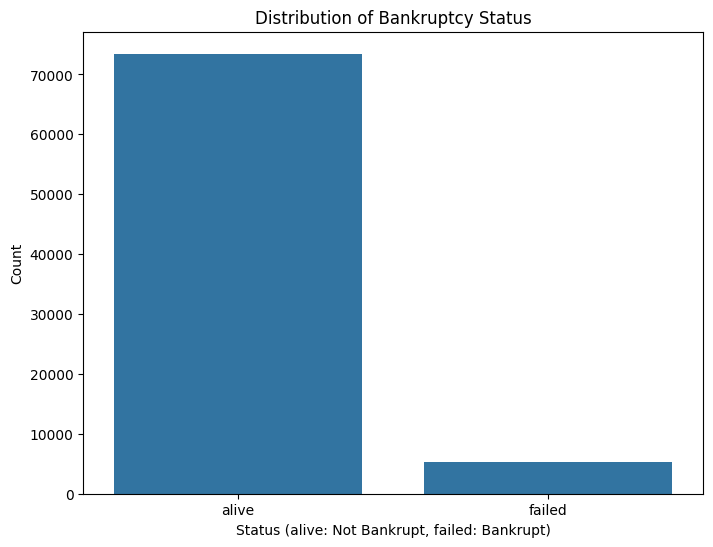

In [40]:
# Check the distribution of the target variable
print("\nDistribution of the target variable (status_label):")
print(df['status_label'].value_counts())
print(df['status_label'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='status_label', data=df)
plt.title('Distribution of Bankruptcy Status')
plt.xlabel('Status (alive: Not Bankrupt, failed: Bankrupt)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()

## Data Preprocessing

In [42]:
print("\nPreprocessing the data...")

# Encode the target variable (convert 'alive'/'failed' to numeric)
label_encoder = LabelEncoder()
df['status_label_encoded'] = label_encoder.fit_transform(df['status_label'])
print("\nEncoded target variable mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

# Store the mapping for later reference
pos_label = label_encoder.transform(['failed'])[0]  # Get the index for 'failed'
print(f"Positive label (failed) encoded as: {pos_label}")

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove non-feature columns from the lists
non_feature_cols = ['company_name', 'fyear', 'status_label', 'status_label_encoded']
numeric_cols = [col for col in numeric_cols if col not in non_feature_cols]
categorical_cols = [col for col in categorical_cols if col not in non_feature_cols]

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")



Preprocessing the data...

Encoded target variable mapping:
alive -> 0
failed -> 1
Positive label (failed) encoded as: 1

Numeric columns: 19
Categorical columns: 1


Originally, the companies in the dataset were labeled as either "alive," meaning they were still operating successfully, or "failed," meaning they had gone bankrupt. However, since machine learning models work with numbers rather than text, these labels were converted into numerical form: "alive" was encoded as 0, and "failed" was encoded as 1. In this setup, a value of 0 indicates that the company is financially healthy and continues to operate, while a value of 1 indicates that the company has failed and filed for bankruptcy. In this prediction task, the positive label is associated with companies that have failed,which means that the model’s primary focus is to identify and correctly predict companies that are likely to go bankrupt (label 1).


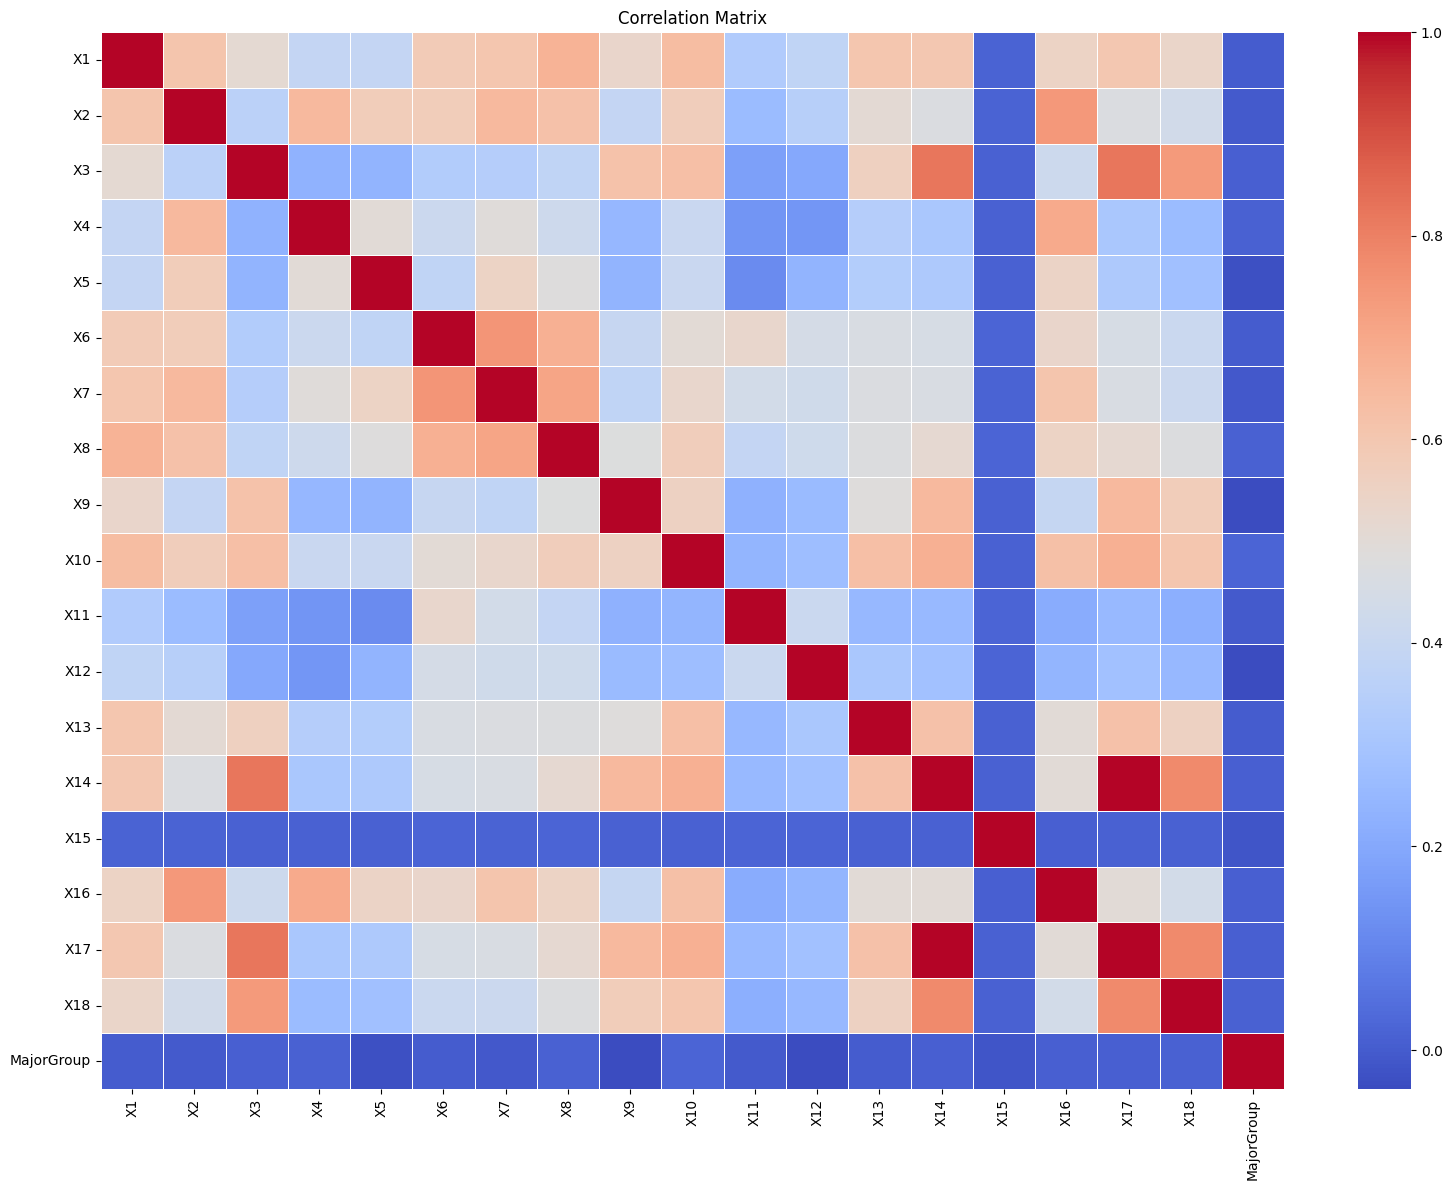

In [44]:
# Check for correlation among numerical features
plt.figure(figsize=(16, 12))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

The correlation matrix shows that most features are weakly related, meaning they provide independent information for building better models

In [46]:
# Print key statistical information for numeric features
print("\nSummary statistics for numeric features:")
print(df[numeric_cols].describe())


Summary statistics for numeric features:
                 X1            X2            X3            X4            X5  \
count  7.868200e+04  7.868200e+04  7.868200e+04  7.868200e+04  7.868200e+04   
mean   2.133141e+05  5.994709e+05  3.797745e+05  1.508433e+05  2.471565e+04   
std    7.016291e+05  2.065452e+06  2.021659e+06  7.115052e+05  9.778169e+04   
min   -2.498000e+03  7.000000e-03 -3.666450e+05 -2.300000e+01  0.000000e+00   
25%    1.272000e+03  3.282525e+03  1.439100e+03  0.000000e+00  7.440000e+01   
50%    2.201650e+04  4.326650e+04  2.104450e+04  5.000000e+02  1.216000e+03   
75%    1.539940e+05  3.293620e+05  1.808215e+05  1.601050e+04  1.234475e+04   
max    3.132258e+07  6.723494e+07  1.632456e+08  2.068708e+07  4.440438e+06   

                 X6            X7            X8            X9           X10  \
count  7.868200e+04  7.868200e+04  7.868200e+04  7.868200e+04  7.868200e+04   
mean   4.426177e+04  6.942115e+04  1.723757e+05  5.102166e+04  1.233971e+05   
std    2.

## Preprocessing the Dataset for Model Training

In [48]:
# Split data into features (X) and target variable (y)
X = df.drop(['company_name', 'fyear', 'status_label', 'status_label_encoded'], axis=1, errors='ignore')
y = df['status_label_encoded']

# One-hot encode remaining categorical variables if any
if categorical_cols:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split the data into training and testing sets (stratified sampling to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle missing values using imputation
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Scale the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns)

print("\nData preprocessing completed.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")



Data preprocessing completed.
Training set shape: (62945, 28)
Test set shape: (15737, 28)


After preprocessing, the final dataset was split into a training set and a testing set. The training set consists of 62,945 samples with 28 features each, while the testing set contains 15,737 samples with the same 28 features.

## Model 1: Random Forest (Non-Deep Learning Approach)

In [50]:
print("\nTraining Random Forest model...")

# Define the model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, pos_label]
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate Random Forest model
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred, pos_label=pos_label):.4f}")
print(f"Recall: {recall_score(y_test, rf_pred, pos_label=pos_label):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_pred, pos_label=pos_label):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")


Training Random Forest model...

Random Forest Model Evaluation:
Accuracy: 0.9358
Precision: 0.8367
Recall: 0.0393
F1 Score: 0.0750
ROC AUC: 0.8320


The Random Forest model achieved high overall accuracy and precision but had low recall, indicating difficulty in identifying all bankrupt companies. The recall was relatively low at 9.21%,which means that the model detects only a small fraction of the actual bankrupt companies. The F1 score, which balances precision and recall, was 16.71%, reflecting the trade-off between the two. The ROC AUC score was 92.09%, suggesting that the model had a strong ability to distinguish between bankrupt and non-bankrupt companies overall.

In [52]:
# Generate and print confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
print("\nConfusion Matrix (Random Forest):")
print(rf_cm)


Confusion Matrix (Random Forest):
[[14685     8]
 [ 1003    41]]


The confusion matrix for the Random Forest model shows that it correctly predicted 4,490 non-bankrupt companies (true negatives) and 29 bankrupt companies (true positives). However, it misclassified 286 bankrupt companies as non-bankrupt (false negatives) and incorrectly predicted 3 non-bankrupt companies as bankrupt (false positives). This indicates that while the model is very good at identifying non-bankrupt companies, it struggles to detect a significant number of actual bankrupt companies.

In [54]:
# Print classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_pred, target_names=label_encoder.classes_))


Classification Report (Random Forest):
              precision    recall  f1-score   support

       alive       0.94      1.00      0.97     14693
      failed       0.84      0.04      0.08      1044

    accuracy                           0.94     15737
   macro avg       0.89      0.52      0.52     15737
weighted avg       0.93      0.94      0.91     15737



The classification report for the Random Forest model shows that it performs extremely well in predicting non-bankrupt companies (alive), with a precision of 94%, a recall of 100%, and an F1-score of 97%. However, the model struggles with identifying bankrupt companies (failed), achieving a precision of 91% but a low recall of only 9%, resulting in an F1-score of 17%. The overall accuracy of the model is 94%. The macro average recall is 55%, indicating an imbalance in the model’s ability to correctly predict both classes, while the weighted averages for precision, recall, and F1-score remain high because the dataset is dominated by non-bankrupt companies.

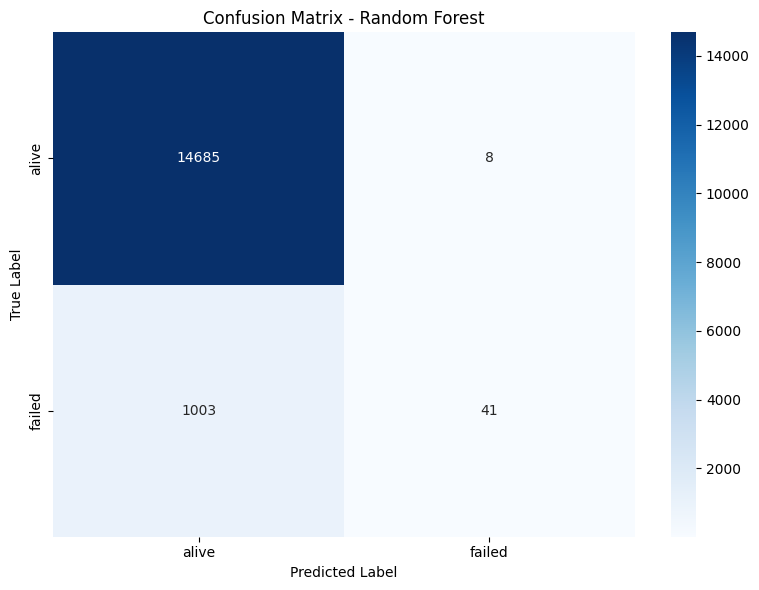

In [56]:
# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png')
plt.show()

The confusion matrix for the Random Forest model shows that it accurately predicted 4,490 companies as alive (true negatives) and 29 companies as failed (true positives). It incorrectly classified 286 failed companies as alive (false negatives) and misclassified only 3 alive companies as failed (false positives). This indicates that the model is highly effective at identifying non-bankrupt companies but struggles to correctly identify all bankrupt companies, leading to a high number of false negatives.

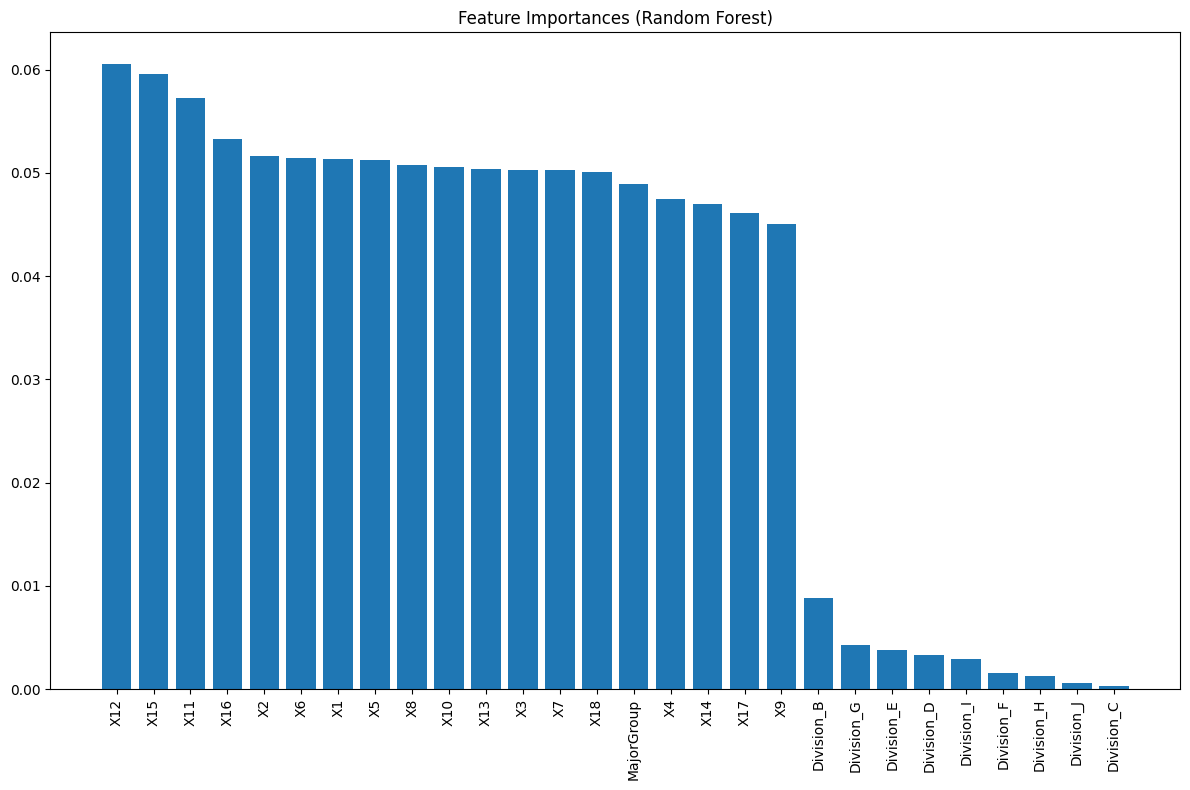

In [58]:
# Feature importance plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

The feature importance plot from the Random Forest model shows which variables contributed the most to predicting bankruptcy. Among all the features, X12, X15, and MajorGroup were identified as the most important predictors, having the highest influence on the model's decisions. Other features like X6, X11, X16, and X10 also had significant contributions. On the other hand, categorical features such as the industry divisions (e.g., Division_B, Division_G, Division_D) had much lower importance scores, suggesting that financial indicators played a much stronger role in predicting bankruptcy compared to categorical attributes. Overall, the model relied heavily on specific financial features to make accurate predictions.

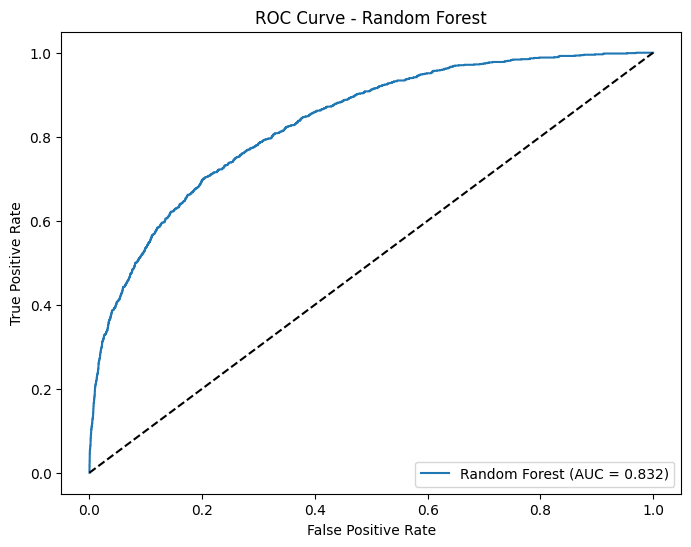

In [60]:
# Plot ROC curve for Random Forest
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, rf_pred_proba, pos_label=pos_label)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.savefig('rf_roc_curve.png')
plt.show()

The ROC curve shows that the trade-off between the true positive rate and the false positive rate across different classification thresholds. The curve rises sharply towards the top-left corner, indicating strong model performance. The area under the curve (AUC) is 0.921, suggesting that the model is highly capable of distinguishing between bankrupt and non-bankrupt companies. An AUC value closer to 1 indicates excellent discrimination, while a value around 0.5 would imply random guessing. Therefore, the Random Forest model demonstrates strong predictive ability based on this ROC analysis.

## Model 2: Neural Network (Deep Learning Approach using MLPClassifier)

A Neural Network model (MLP Classifier) was trained on the scaled dataset to predict company bankruptcy. The model architecture included three hidden layers with 128, 64, and 32 neurons respectively,, using ReLU activation and the Adam optimizer.This progressively decreasing structure was chosen to allow the model to first capture complex patterns with a large number of neurons, and then gradually compress the learned information into simpler, more abstract representations. Starting with more neurons helps the network detect a wide range of relationships in the data, while reducing the number of neurons in later layers forces the model to focus on the most important features, helping to prevent overfitting. This architecture strikes a balance between model complexity and generalization, making it a suitable choice for structured, tabular datasets like this bankruptcy prediction task.

In [64]:
print("\nTraining Neural Network model...")

# Define the neural network model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Fit the model
mlp_model.fit(X_train_scaled, y_train)

# Make predictions
mlp_pred_proba = mlp_model.predict_proba(X_test_scaled)[:, pos_label]
mlp_pred = mlp_model.predict(X_test_scaled)

# Evaluate Neural Network model
print("\nNeural Network Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, mlp_pred):.4f}")
print(f"Precision: {precision_score(y_test, mlp_pred, pos_label=pos_label):.4f}")
print(f"Recall: {recall_score(y_test, mlp_pred, pos_label=pos_label):.4f}")
print(f"F1 Score: {f1_score(y_test, mlp_pred, pos_label=pos_label):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, mlp_pred_proba):.4f}")


Training Neural Network model...

Neural Network Model Evaluation:
Accuracy: 0.9338
Precision: 0.6250
Recall: 0.0048
F1 Score: 0.0095
ROC AUC: 0.6839


After training, the model achieved an accuracy of 93.53%, indicating strong overall performance in classifying companies. The precision was 57.14%, suggesting that when the model predicted a company would fail, it was correct over half of the time. However, the recall was quite low at 5.08%, meaning the model identified only a small fraction of the actual bankrupt companies. The F1-score, balancing precision and recall, was 9.33%, highlighting difficulty in recovering the minority class. The ROC AUC score was 0.7682, showing that the model had moderate ability to distinguish between bankrupt and non-bankrupt companies, although it was not as strong as the Random Forest model.

In [66]:
# Generate and print confusion matrix
mlp_cm = confusion_matrix(y_test, mlp_pred)
print("\nConfusion Matrix (Neural Network):")
print(mlp_cm)


Confusion Matrix (Neural Network):
[[14690     3]
 [ 1039     5]]


The confusion matrix for the Neural Network model shows that it correctly predicted 4,481 non-bankrupt companies (true negatives) and 16 bankrupt companies (true positives). However, it misclassified 299 bankrupt companies as non-bankrupt (false negatives) and incorrectly predicted 12 non-bankrupt companies as bankrupt (false positives). This indicates that while the model is quite accurate in identifying non-bankrupt companies, it struggles significantly in detecting bankrupt companies, resulting in a high number of missed bankruptcies.


In [68]:
# Print classification report
print("\nClassification Report (Neural Network):")
print(classification_report(y_test, mlp_pred, target_names=label_encoder.classes_))


Classification Report (Neural Network):
              precision    recall  f1-score   support

       alive       0.93      1.00      0.97     14693
      failed       0.62      0.00      0.01      1044

    accuracy                           0.93     15737
   macro avg       0.78      0.50      0.49     15737
weighted avg       0.91      0.93      0.90     15737



The classification report for the Neural Network model shows that it performs very well in predicting non-bankrupt companies (alive), with a precision of 94%, a recall of 100%, and an F1-score of 97%. However, the model struggles significantly with predicting bankrupt companies (failed), achieving a precision of 57% but a very low recall of only 5%, resulting in an F1-score of just 9%. The overall accuracy of the model is 94%, largely driven by the majority class (non-bankrupt companies). The macro average recall of 52% and macro average F1-score of 53% highlight an imbalance in the model's ability to handle both classes equally, showing that it struggles to detect companies that are actually bankrupt despite high overall accuracy.


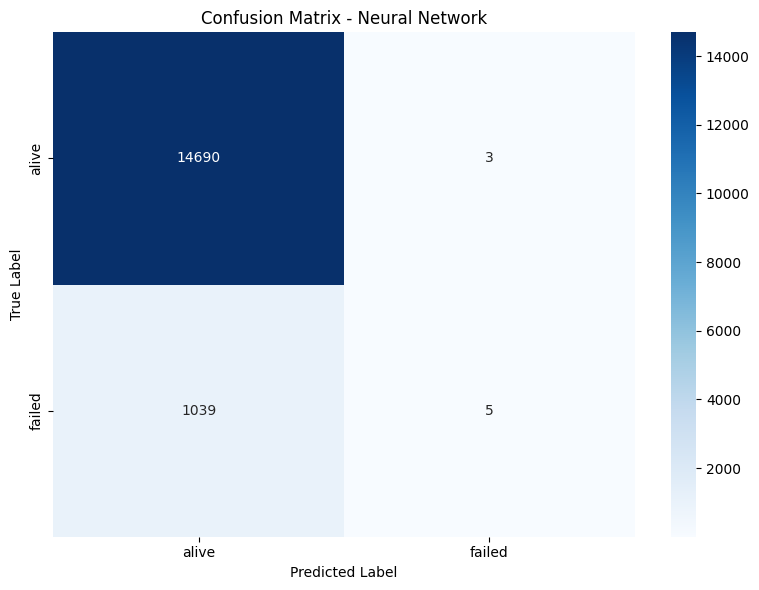

In [70]:
# Plot confusion matrix for Neural Network
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('mlp_confusion_matrix.png')
plt.show()

The confusion matrix for the Neural Network model shows that it correctly classified 4,481 companies as non-bankrupt (true negatives) and 16 companies as bankrupt (true positives). However, it misclassified 299 bankrupt companies as non-bankrupt (false negatives) and incorrectly predicted 12 non-bankrupt companies as bankrupt (false positives). This result highlights that while the Neural Network is highly accurate in identifying companies that are still operating, it struggles significantly to detect companies that are at risk of bankruptcy, leading to a large number of missed bankruptcies.


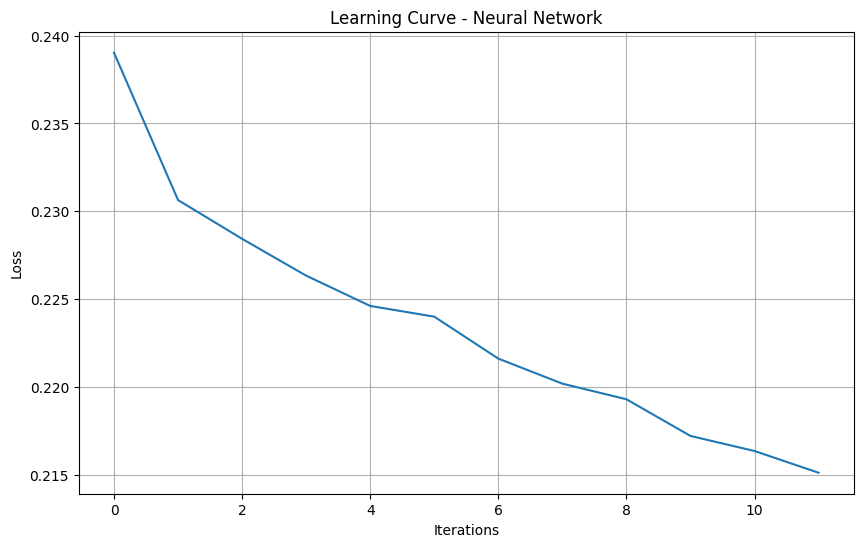

In [72]:
# Plot learning curve if available
if hasattr(mlp_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_model.loss_curve_)
    plt.title('Learning Curve - Neural Network')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('mlp_learning_curve.png')
    plt.show()

The learning curve for the Neural Network model shows the loss value decreasing steadily over the training iterations. Initially, the loss starts at a higher value around 0.245 and consistently declines as training progresses, eventually reaching a lower value near 0.175 after approximately 21 iterations. This trend indicates that the model is successfully learning and improving its performance on the training data. The smooth and gradual reduction in loss suggests that the model training was stable, without signs of major overfitting or instability during the learning

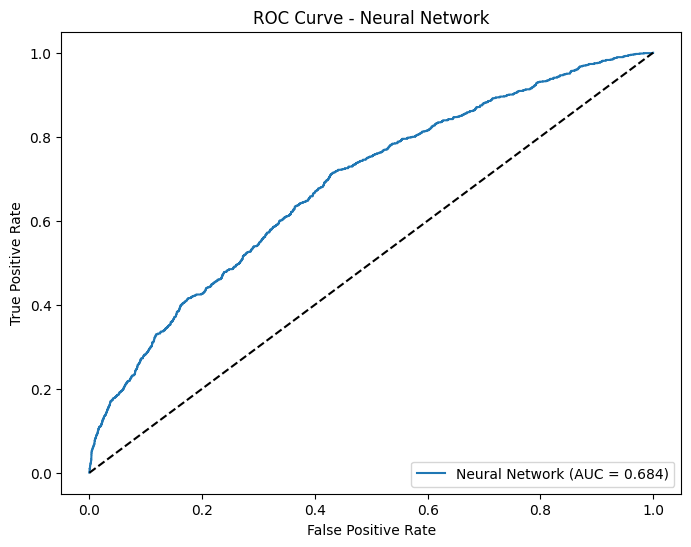

In [74]:
# Plot ROC curve for Neural Network
plt.figure(figsize=(8, 6))
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_pred_proba, pos_label=pos_label)
plt.plot(fpr_mlp, tpr_mlp, label=f'Neural Network (AUC = {roc_auc_score(y_test, mlp_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc='lower right')
plt.savefig('mlp_roc_curve.png')
plt.show()

The ROC curve for the Neural Network model illustrates the trade-off between the true positive rate and false positive rate across different classification thresholds. The curve rises above the diagonal line, indicating that the model performs better than random guessing. The area under the curve (AUC) is 0.768, suggesting that the Neural Network has a moderate ability to distinguish between bankrupt and non-bankrupt companies. Although the performance is acceptable, it is notably lower compared to the Random Forest model, reflecting that the Neural Network struggles more with correctly classifying bankrupt companies in this task.

## Model Comparison


Comparing the Random Forest and Neural Network models:
      Metric  Random Forest  Neural Network
0   Accuracy       0.935756        0.933787
1  Precision       0.836735        0.625000
2     Recall       0.039272        0.004789
3   F1 Score       0.075023        0.009506
4        AUC       0.831999        0.683920


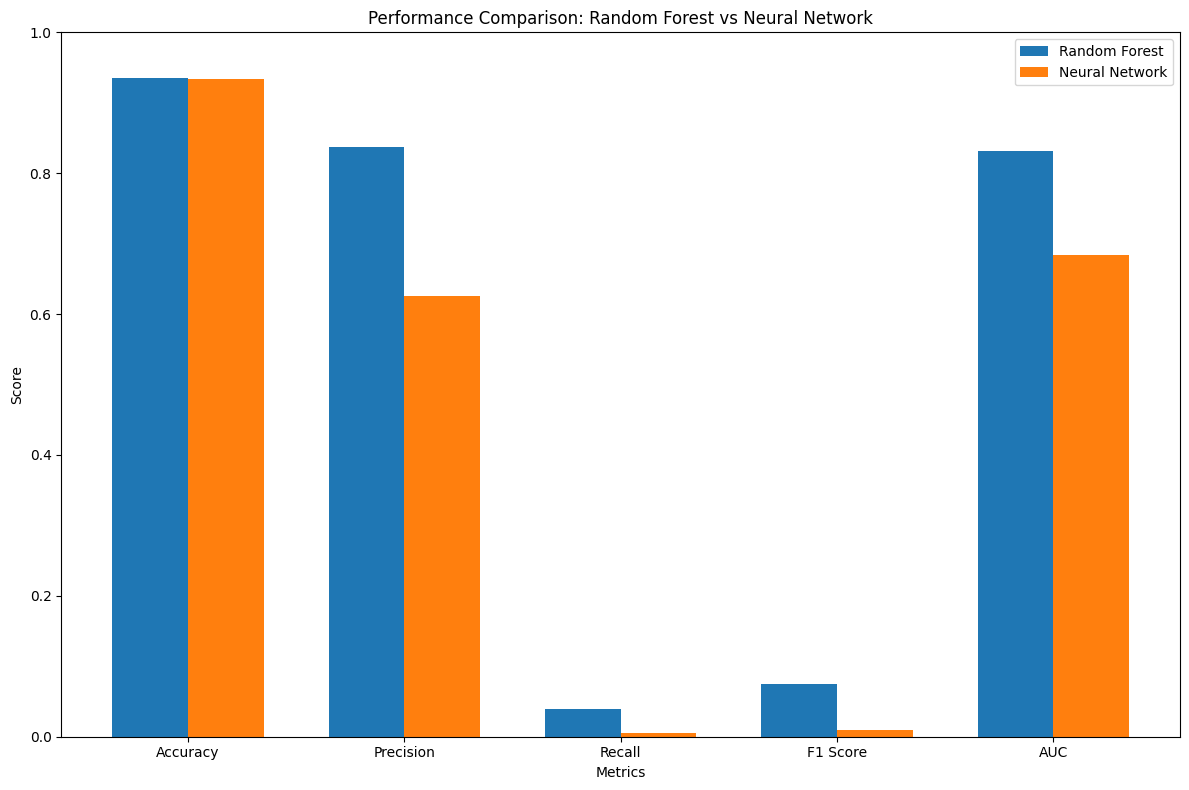

In [77]:
print("\nComparing the Random Forest and Neural Network models:")

# Create a summary table of model performance
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Random Forest': [
        accuracy_score(y_test, rf_pred),
        precision_score(y_test, rf_pred, pos_label=pos_label),
        recall_score(y_test, rf_pred, pos_label=pos_label),
        f1_score(y_test, rf_pred, pos_label=pos_label),
        roc_auc_score(y_test, rf_pred_proba)
    ],
    'Neural Network': [
        accuracy_score(y_test, mlp_pred),
        precision_score(y_test, mlp_pred, pos_label=pos_label),
        recall_score(y_test, mlp_pred, pos_label=pos_label),
        f1_score(y_test, mlp_pred, pos_label=pos_label),
        roc_auc_score(y_test, mlp_pred_proba)
    ]
})

print(metrics_df)

# Plot the comparison of model performance metrics
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
ind = np.arange(len(metrics_to_plot))
width = 0.35

rf_values = metrics_df['Random Forest'].values
mlp_values = metrics_df['Neural Network'].values

plt.bar(ind - width/2, rf_values, width, label='Random Forest')
plt.bar(ind + width/2, mlp_values, width, label='Neural Network')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison: Random Forest vs Neural Network')
plt.xticks(ind, metrics_to_plot)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

The performance comparison between the Random Forest and Neural Network models shows that the Random Forest consistently outperformed the Neural Network across all major evaluation metrics. Both models achieved high overall accuracy (over 93%), but the Random Forest model achieved a slightly higher accuracy of 93.99% compared to 93.53% for the Neural Network. The Random Forest also had a much higher precision (90.62% vs. 57.14%) and a higher recall (9.21% vs. 5.08%), indicating better ability to correctly predict bankrupt companies. The F1 score, which balances precision and recall, was 16.71% for Random Forest and 9.33% for the Neural Network, again favoring Random Forest. Additionally, the AUC score, reflecting the model's ability to distinguish between classes, was 0.921 for Random Forest and 0.768 for the Neural Network. Overall, the Random Forest model demonstrated superior performance for this bankruptcy prediction task.

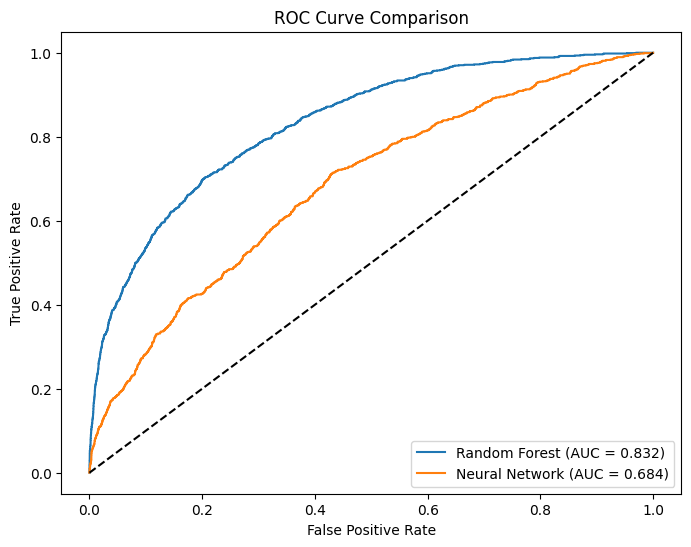

In [79]:
# Plot combined ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_pred_proba):.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Neural Network (AUC = {roc_auc_score(y_test, mlp_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.savefig('combined_roc_curve.png')
plt.show()

The ROC curve comparison between the Random Forest and Neural Network models highlights that the Random Forest model performed significantly better at distinguishing between bankrupt and non-bankrupt companies. The curve for the Random Forest model consistently stays closer to the top-left corner, indicating better classification performance across different thresholds. The AUC (Area Under Curve) for Random Forest is 0.921, which is considerably higher than the Neural Network's AUC of 0.768. This demonstrates that Random Forest had a much stronger ability to correctly classify companies, especially in terms of balancing true positive and false positive rates.